In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.colors as mcolors
import numpy as np
import collections
import seaborn as sns
from pygam import LogisticGAM
import matplotlib.tri as tri
from scipy.interpolate import griddata
from shapely.geometry import polygon 

In [5]:
#Read combined data csv, grab neccasary columns
data = pd.read_csv('pitch_data_2008_2021.csv')
pitch_data = data[['pitch_name', 'plate_x', 'plate_z', 'description', 'stand', 'inning_topbot', 'strikes', 'inning', 'game_year']]

#Remove pitches that were swung at, reclassicify blocked balls as balls
pitch_data = pitch_data[pitch_data['description'].isin(['called_strike', 'ball', 'blocked_ball'])]
pitch_data['description'].replace('blocked_ball', 'ball', inplace = True)
pitch_data.dropna(axis=0, how='any', inplace= True)

#Function grabbing the true strikezone based on how likely an Umpire will call a ball at a certain x,z location a ball or a strike
def true_strikezone(data):
    #Set up data for General Additive Model
    classifier_data = data[['description', 'plate_x', 'plate_z']]
    #Predictor Variables, the x and z coordinates of the pitches (Where it crosses the plate)
    X = classifier_data[['plate_x', 'plate_z']]
    #Response Variable, whether the ump called the pitch a ball or a strike
    y = classifier_data['description']
    classifier_data['description'].replace('ball', 0, inplace = True)
    classifier_data['description'].replace('called_strike', 1, inplace = True)
    #Build the logistic GAM
    gam = LogisticGAM().fit(X, y)
    #For every pitch, predict whether it would be called a ball or a strike using a logistic model
    classifier_data['pred'] = gam.predict(X)
    classifier_data['pred'].replace(False, 'ball', inplace = True)
    classifier_data['pred'].replace(True, 'strike', inplace = True)
    
    fig, ax = plt.subplots(figsize =(10,10))

    # Outer Zone (To gage length from strikezone)

    plt.plot([-2,-2],[0,5], color="black")     
    plt.plot([2,2],[0,5], color="black")
    plt.plot([-2,2],[0,0], color="black")
    plt.plot([-2,2],[5,5], color="black")

    #Strikezone

    plt.plot([-.725,-.725],[1.5,3.5], color="black")  #left line
    plt.plot([.725,.725],[1.5,3.5], color="black")   #right line
    plt.plot([-.725,.725],[1.5,1.5], color="black")  #bottom line
    plt.plot([-.725,.725],[3.5,3.5], color="black")  #top line

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    palette ={"ball": "green", "strike": "red"}    #differentiating balls and strikes

    ax = sns.scatterplot(data= classifier_data, x='plate_x', y='plate_z', hue = 'pred', s = 7, palette = palette)

    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,24,44,88,89,93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

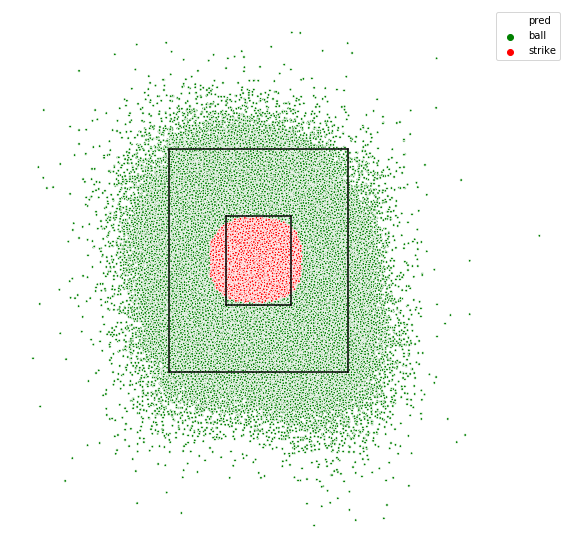

In [6]:
#replace pitch_data with your data
true_strikezone(pitch_data)

In [7]:
def contour_plot(data):
    
    #Set up Logistic Regression like above
    classifier_data = data[['description', 'plate_x', 'plate_z']]
    X = classifier_data[['plate_x', 'plate_z']]
    y = classifier_data['description']
    classifier_data['description'].replace('ball', 0, inplace = True)
    classifier_data['description'].replace('called_strike', 1, inplace = True)
    gam = LogisticGAM().fit(X, y)
    classifier_data['pred'] = gam.predict_mu(X)
    X = classifier_data['plate_x'].to_numpy()
    Y = classifier_data['plate_z'].to_numpy()
    Z = classifier_data['pred'].to_numpy()
    
    #Create a countour plane, adding in levels of granularity and bounds
    ngridx = 100
    ngridy = 200
    xi = np.linspace(-2, 2, ngridx)
    yi = np.linspace(.5, 4.5, ngridy)
    #Apply the pitches to the contour plane, "holding" the predictor value from the logistic regression model (Percent chance that pitch was called a strike)
    zi = griddata((X, Y), Z, (xi[None, :], yi[:, None]), method='linear')

    
    #Create figure
    fig, ax = plt.subplots(figsize =(10,10))


    #Strikezone

    plt.plot([-.725,-.725],[1.5,3.5], color="red")  #left line
    plt.plot([.725,.725],[1.5,3.5], color="red")   #right line
    plt.plot([-.725,.725],[1.5,1.5], color="red")  #bottom line
    plt.plot([-.725,.725],[3.5,3.5], color="red")  #top line

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    #Draw countour lines at the Z values .5 and .9 - representing the points where pitches have a 50% and 90% chance of being called a strike, respectively
    levels = [.5, .9]
    cs = ax.contour(xi, yi, zi, levels= levels, linewidths= 3, colors=['black', 'blue'])
        
    #Calculate area of each contour circle
    for i in range(len(cs.collections)):
        p = cs.collections[i].get_paths()[0]
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        poly = polygon.Polygon([(i[0], i[1]) for i in zip(x,y)])
        print ("r = " + str(levels[1-i]) + ": a =" + str(poly.area))
            
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


r = 0.9: a =3.411334291163624
r = 0.5: a =1.758725766840408


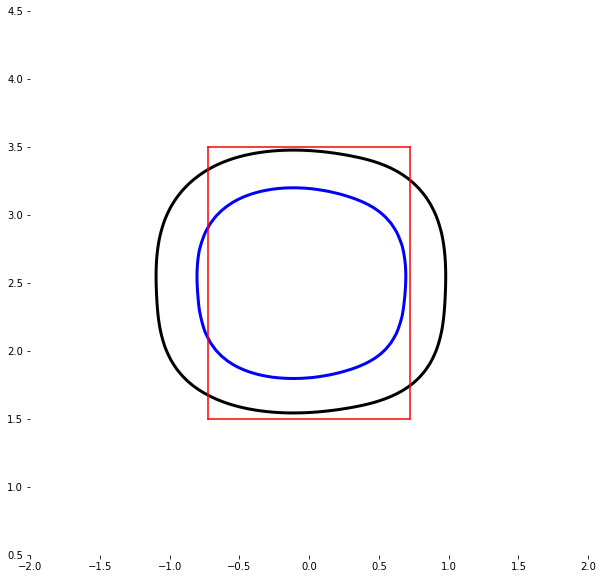

In [9]:
contour_plot(pitch_data)

In [10]:
def create_combined_viz(data, title):
    #Prepare Data
    pitch_data = data[['pitch_name', 'plate_x', 'plate_z', 'description', 'stand']]
    pitch_data = pitch_data[pitch_data['description'].isin(['called_strike', 'ball', 'blocked_ball'])]
    pitch_data['description'].replace('blocked_ball', 'ball', inplace = True)

    #Create classic 9 zones of the baseball zone
    area_1_bounds = [-.725, -.241667, 2.833, 3.5]
    area_2_bounds = [-.241667, .241667, 2.833, 3.5]
    area_3_bounds = [.241667, .725, 2.833, 3.5]
    area_4_bounds = [-.725, -.241667, 2.166, 2.833]
    area_5_bounds = [-.241667, .241667, 2.166, 2.833]
    area_6_bounds = [.241667, .725, 2.166, 2.833]
    area_7_bounds = [-.725, -.241667, 1.5, 2.166]
    area_8_bounds = [-.241667, .241667, 1.5, 2.166]
    area_9_bounds = [.241667, .725, 1.5, 2.166]

    zones = [area_1_bounds, area_2_bounds, area_3_bounds, area_4_bounds, area_5_bounds, area_6_bounds, area_7_bounds, area_8_bounds, area_9_bounds]

    outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]
    
    #Create 4 zones outside of srikezone (up and away, up and in, down and away, down and in)
    outside_1_bounds1 = [-.9666, -.725, 2.5, 3.833]
    outside_1_bounds2 = [-.725, 0, 3.5, 3.833]
    outside_2_bounds1 = [.725,.9666, 2.5, 3.833]
    outside_2_bounds2 = [.725, .9666, 3.5, 3.833]
    outside_3_bounds1 = [-.9666, -.725, 1.1666, 1.5]
    outside_3_bounds2 = [-.725, 0, 1.1666, 1.5]
    outside_4_bounds1 = [.725, .9666, 1.1666, 1.5]
    outside_4_bounds2 = [0, .725, 1.1666, 1.5]

    outside_zones = [(outside_1_bounds1, outside_1_bounds2), (outside_2_bounds1, outside_2_bounds2), (outside_3_bounds1, outside_3_bounds2), (outside_4_bounds1, outside_4_bounds2)]

    #Set up Logistic Regression like above
    classifier_data = data[['description', 'plate_x', 'plate_z']]
    X = classifier_data[['plate_x', 'plate_z']]
    y = classifier_data['description']
    classifier_data['description'].replace('ball', 0, inplace = True)
    classifier_data['description'].replace('called_strike', 1, inplace = True)
    gam = LogisticGAM().fit(X, y)
    classifier_data['pred'] = gam.predict_mu(X)
    X = classifier_data['plate_x'].to_numpy()
    Y = classifier_data['plate_z'].to_numpy()
    Z = classifier_data['pred'].to_numpy()
    #Create a countour plane, adding in levels of granularity and bounds
    ngridx = 100
    ngridy = 150
    xi = np.linspace(-1.5, 1.5, ngridx)
    yi = np.linspace(1, 4, ngridy)
    #Apply the pitches to the contour plane, "holding" the predictor value from the logistic regression model (Percent chance that pitch was called a strike)
    zi = griddata((X, Y), Z, (xi[None, :], yi[:, None]), method='linear')
    
    #Find center for each zone for data visualization
    centers = []
    for zone in zones:
        zone_center = []
        zone_center.append(((zone[1] - zone[0])/2 + zone[0])-.175)
        zone_center.append((zone[3] - zone[2])/2 + zone[2]-.05)
        centers.append(zone_center)
    centers
    
    #Grab Pitches within a certain zone
    def grab_pitches_from_zone(data, zone_bounds):
        zone_data = data[data['plate_x'] > zone_bounds[0]]
        zone_data = zone_data[zone_data['plate_x'] < zone_bounds[1]]
        zone_data = zone_data[zone_data['plate_z'] > zone_bounds[2]]
        zone_data = zone_data[zone_data['plate_z'] < zone_bounds[3]]
        return zone_data
    #Calculate the % of pitches Home Plate Umpires Called Correctly in a certain zone (inside the strikezone)
    def pct_correct_per_zone(data, zone_bounds):
        zone_data = grab_pitches_from_zone(data, zone_bounds)
        return (zone_data['description'].value_counts()['called_strike'] / zone_data['description'].size)*100
    #Calculate the % of pitches Home Plate Umpires Called Correctly in a certain zone (outside the strikezone)
    def pct_correct_per_zone_outside(data, zone_bounds1, zone_bounds2):
        zone_data1 = grab_pitches_from_zone(data, zone_bounds1)
        zone_data2 = grab_pitches_from_zone(data, zone_bounds2)
        return ((zone_data1['description'].value_counts()['called_strike'] + zone_data2['description'].value_counts()['called_strike']) / (zone_data1['description'].size + zone_data2['description'].size))*100
    #Create list of percentage values (inside the strikezone)
    def inside_zone_list(data):
        inside_zone_list = []
        for zone in zones:
               inside_zone_list.append(pct_correct_per_zone(data, zone))
        return inside_zone_list
    #Create list of percentage values (outside the strikezone)
    def outside_zone_list(data):
        outside_zone_list = []
        for zone in range(len(outside_zones)):
            try:
                 outside_zone_list.append(pct_correct_per_zone_outside(data, outside_zones[zone][0], outside_zones[zone][1]))
            except:
                pass
        return  outside_zone_list

    def create_viz(data):
        cmap = plt.get_cmap('coolwarm')
        out_norm = mcolors.Normalize(vmin=0, vmax=50)
        outside_rectangles = [[(-.9666,2.5), .24166, 1.333, (-.725, 3.5), .725, .333], [(.9666,2.5), -.24166, 1.333, (.725, 3.5), -.725, .333], [(-.9666,2.5), .24166, -1.333, (-.725, 1.5), .725, -.333], [(.9666,2.5), -.24166, -1.333, (.725, 1.5), -.725, -.333]]
        cmap = plt.get_cmap('coolwarm')
        norm = mcolors.Normalize(vmin=60, vmax=100)
        rectangles = [(-.725,2.833), (-.241667,2.833), (.241667, 2.833), (-.725,2.166), (-.241667,2.166), (.241667, 2.166), (-.725,1.5), (-.241667,1.5), (.241667, 1.5)]

        #Create figure
        fig, ax = plt.subplots(figsize =(10,10))


        plt.plot([-.725,-.725],[1.5,3.5], color="red")
        plt.plot([.725,.725],[1.5,3.5], color="red")
        plt.plot([-.725,.725],[1.5,1.5], color="red")
        plt.plot([-.725,.725],[3.5,3.5], color="red")


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        for i, value in enumerate(inside_zone_list(data)): #inside data here
            rect = patch.Rectangle(rectangles[i], .4833, .6666, linewidth=1, edgecolor='black', facecolor=cmap(norm(value)), alpha = .5)
            ax.add_patch(rect)
        
        #Draw countour lines at the Z values .5 and .9 - representing the points where pitches have a 50% and 90% chance of being called a strike, respectively
        levels = [.5, .9]
        cs = ax.contour(xi, yi, zi, levels= levels, linewidths= 3, colors=['black', 'blue'])
        
        #Calculate area of each contour circle
        for i in range(len(cs.collections)):
            p = cs.collections[i].get_paths()[0]
            v = p.vertices
            x = v[:,0]
            y = v[:,1]
            poly = polygon.Polygon([(i[0], i[1]) for i in zip(x,y)])
            print ("r = " + str(levels[i]) + ": a =" + str(poly.area))

        ax.set_title(title, fontsize = 24)
        plt.show()
        
    return create_viz(data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.0355855266955682
r = 0.9: a =1.097066527109846


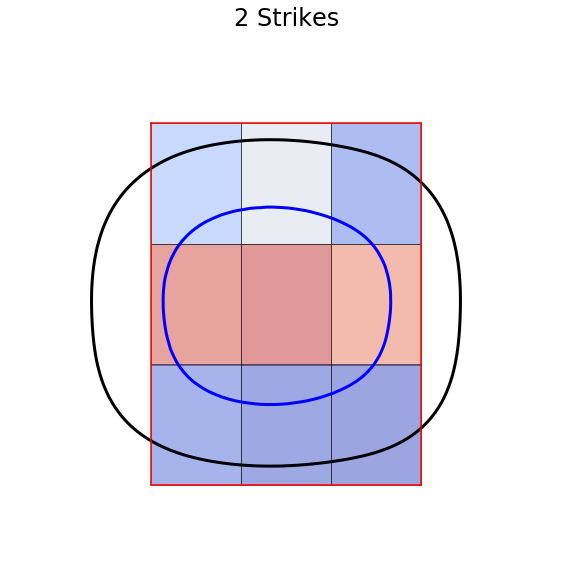

In [11]:
#Combined Viz of Pitches pitched with a 2-strike Count
create_combined_viz(pitch_data[pitch_data['strikes'] == 2], "2 Strikes")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.4413505374372044
r = 0.9: a =1.8652255940098392


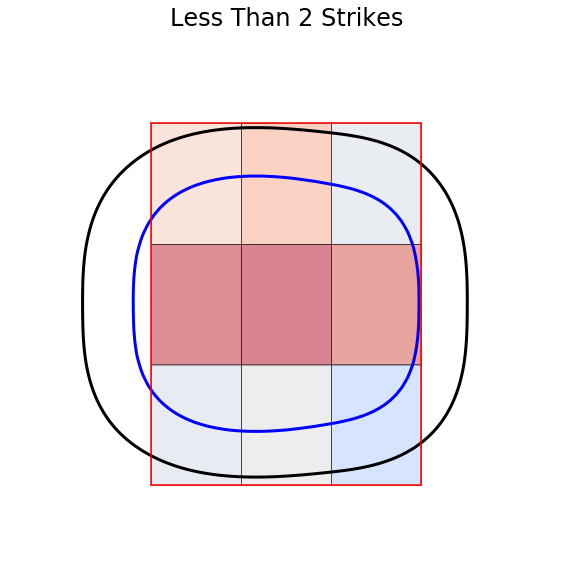

In [12]:
create_combined_viz(pitch_data[pitch_data['strikes'] != 2], "Less Than 2 Strikes")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.2332815737037155
r = 0.9: a =1.6273766609490792


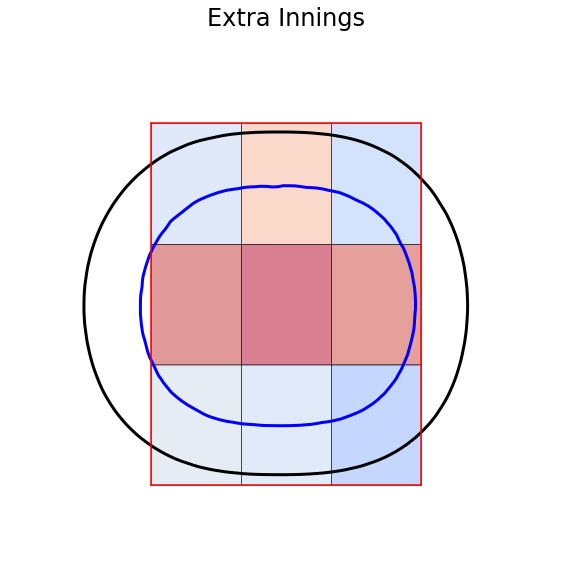

In [13]:
create_combined_viz(pitch_data[pitch_data['inning'] > 9], "Extra Innings")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.3998517203618666
r = 0.9: a =1.7972153262371935


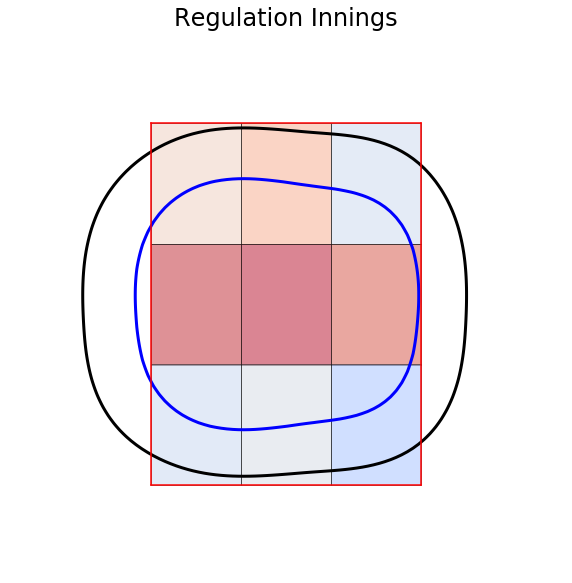

In [14]:
create_combined_viz(pitch_data[pitch_data['inning'] <= 9], "Regulation Innings")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.4356753977350576
r = 0.9: a =1.7777962858258987


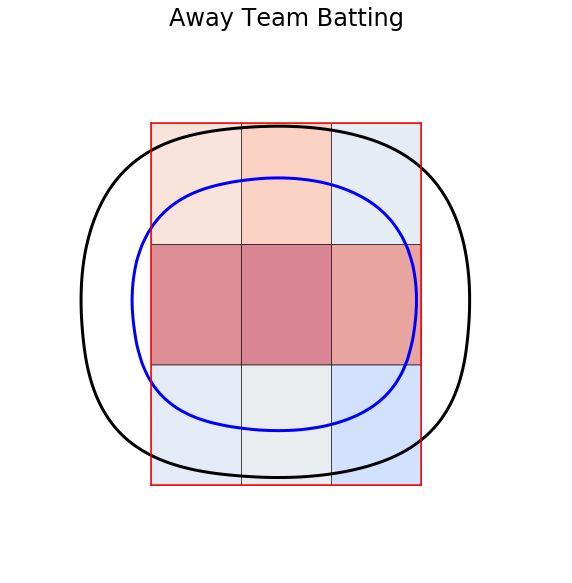

In [15]:
create_combined_viz(pitch_data[pitch_data['inning_topbot'] =='Top'], "Away Team Batting")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r = 0.5: a =3.371717659344448
r = 0.9: a =1.7697157516390902


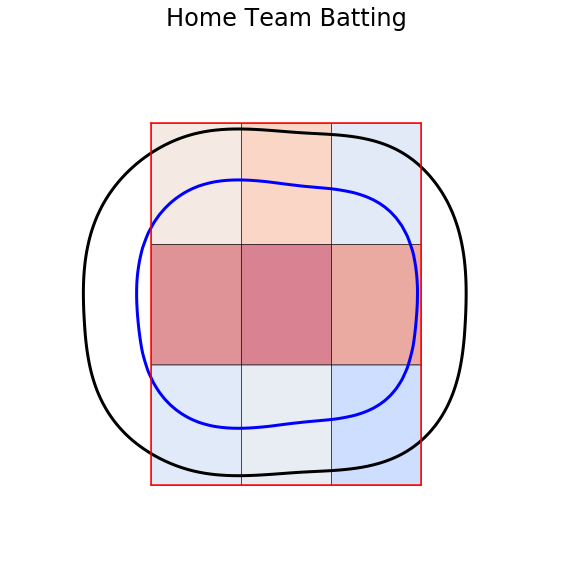

In [16]:
create_combined_viz(pitch_data[pitch_data['inning_topbot'] =='Bot'], "Home Team Batting")